In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Tuple, Optional, Union

import gcsfs
import os
import sys
import json
sys.path.append(os.path.abspath(os.path.join('diffusionsim')))
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/srv/conda/envs/notebook'

fs = gcsfs.GCSFileSystem()
fs.ls("gs://leap-persistent/sammyagrawal/") # List files in the bucket where the E3SM-MMF dataset is stored

['leap-persistent/sammyagrawal/input_climsim.npy',
 'leap-persistent/sammyagrawal/output_climsim.npy']

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import xbatcher
import torch.nn.functional as F

import diffusers
import diffusionsim as diff
import diffusionsim.training_utils as tru
from diffusionsim import mydatasets as data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Script Setup

#### define and save all configs

In [6]:
from pprint import pprint

In [7]:
unet = tru.UNetParams()
unet.block_out_channels = (128, 256, 512)
unet.down_block_types = ("DownBlock2D", "DownBlock2D", "DownBlock2D")
unet.up_block_types = ("UpBlock2D", "UpBlock2D", "UpBlock2D")
unet.layers_per_block = 1
unet.norm_num_groups = 4
unet

UNetParams(sample_size=(16, 24), in_channels=128, out_channels=128, block_out_channels=(128, 256, 512), down_block_types=('DownBlock2D', 'DownBlock2D', 'DownBlock2D'), up_block_types=('UpBlock2D', 'UpBlock2D', 'UpBlock2D'), layers_per_block=1, norm_num_groups=4)

In [8]:
scheduler = tru.SchedulerParams()
scheduler

SchedulerParams(num_train_timesteps=100, beta_schedule='linear', clip_sample=False, clip_sample_range=4.0)

In [9]:
mconfig = diff.ModelConfig()
mconfig.model_type = "ddpm_diffusion"
mconfig.unet = unet
mconfig.scheduler = scheduler
pprint(asdict(mconfig))

{'ae_hidden_dims': [64, 32, 16],
 'data_vars': 'v1',
 'disable_enc_logstd_bias': True,
 'latent_dims': 16,
 'model_type': 'ddpm_diffusion',
 'num_channels': 128,
 'scheduler': {'beta_schedule': 'linear',
               'clip_sample': False,
               'clip_sample_range': 4.0,
               'num_train_timesteps': 100},
 'scheduler_type': 'ddpm',
 'unet': {'block_out_channels': (128, 256, 512),
          'down_block_types': ('DownBlock2D', 'DownBlock2D', 'DownBlock2D'),
          'in_channels': 128,
          'layers_per_block': 1,
          'norm_num_groups': 4,
          'out_channels': 128,
          'sample_size': (16, 24),
          'up_block_types': ('UpBlock2D', 'UpBlock2D', 'UpBlock2D')}}


In [12]:
dl_params = tru.TrainLoaderParams()
dl_params.batch_size = 128
dl_params.shuffle = True
dl_params.num_workers = 8
dl_params.prefetch_factor = 4
dl_params.persistent_workers = True
dl_params.multiprocessing_context = "forkserver"
dconfig = tru.DataConfig()
dconfig.train_test_split = [1.0]
dconfig.dataloader_params = dl_params
pprint(asdict(dconfig))

{'chunksize': {},
 'climsim_type': 'low-res',
 'data_vars': 'v1',
 'dataloader_params': {'batch_size': 128,
                       'multiprocessing_context': 'forkserver',
                       'num_workers': 8,
                       'persistent_workers': True,
                       'pin_memory': True,
                       'prefetch_factor': 4,
                       'shuffle': True},
 'dataset_type': 'XBatchDataset',
 'norm_info': 'image',
 'prenormalize': False,
 'train_test_split': [1.0],
 'use_tendencies': False,
 'xarr_subsamples': (36, 210240, 144)}


In [13]:
tconfig = diff.TrainingConfig()
tconfig.exp_id = 'full_dataset_testrun'
tconfig.num_epochs = 20
tconfig.phases = ['train']
tconfig.train_test_split=[1.0]

tconfig.lr_scheduler = 'get_cosine_schedule_with_warmup'
tconfig.lr_warmup_steps = 100
tconfig.learning_rate = 5e-5
tconfig.batch_logging_interval = 25
tconfig.batch_checkpoint_interval = 100
tconfig.save_best_epoch = True
tconfig.log_gradients = False

pprint(asdict(tconfig))

{'batch_checkpoint_interval': 100,
 'batch_logging_interval': 25,
 'beta': 0.2,
 'betas': (0.9, 0.999),
 'clip_gradients': True,
 'distributed_training': False,
 'exp_id': 'full_dataset_testrun',
 'learning_rate': 5e-05,
 'log_gradients': False,
 'lr_scheduler': 'get_cosine_schedule_with_warmup',
 'num_epochs': 20,
 'optimizer': 'adam',
 'phases': ['train'],
 'push_to_hub': False,
 'save_best_epoch': True}


In [14]:
def setup_run(tconfig, mconfig, dconfig, run_id, exp_dir="./experiments"):
    from pathlib import Path
    base_dir = os.path.join(exp_dir, tconfig.exp_id)
    Path(base_dir).mkdir(parents=True, exist_ok=True)

    with open(os.path.join(base_dir, f"{run_id}.json"), "w") as f:
        json.dump(dict(
            training_config=asdict(tconfig),
            model_config=asdict(mconfig),
            data_config=asdict(dconfig),
        ), f)
        

In [15]:
setup_run(tconfig, mconfig, dconfig, "trial_1b")

### Load Model and Dataset

In [5]:
exp_id = "full_dataset_testrun"
run_id = "trial_1"
tconfig, mconfig, dconfig = tru.load_config(run_id, exp_id)

In [6]:
model = tru.load_model(mconfig)

In [7]:
cpath = os.path.join("experiments", exp_id, f"{run_id}-ckpt.pt")
model.load_state_dict(torch.load(cpath, map_location=torch.device('cpu')))


<All keys matched successfully>

In [18]:
dconfig.dataloader_params.batch_size = 128
dconfig

DataConfig(dataset_type='XBatchDataset', climsim_type='low-res', train_test_split=[1.0, 0.0], dataloader_params=TrainLoaderParams(batch_size=128, shuffle=False, num_workers=0, prefetch_factor=None, persistent_workers=False, multiprocessing_context=None, pin_memory=True), xarr_subsamples=[36, 210240, 144], data_vars='v1', use_tendencies=False, norm_info='image', prenormalize=False, chunksize={})

In [19]:
trainer = tru.setup_trainer(exp_id, run_id, tconfig, mconfig, dconfig)

{"event": "get-batch start", "time": 1727163455.008665, "pid": 2137, "batch_idx": 0}
{"event": "get-batch end", "time": 1727163457.1926517, "pid": 2137, "batch_idx": 0, "duration": 2.183980703353882}


In [6]:
trainer.losses

AttributeError: 'DiffusionTrainer' object has no attribute 'losses'

In [50]:
dl = trainer.dataloaders['train']
len(dl)

1642

In [48]:
batch = next(iter(dl))
batch.shape

{"event": "get-batch start", "time": 1727156669.6265342, "pid": 1161, "batch_idx": 0}
{"event": "get-batch end", "time": 1727156672.7288375, "pid": 1161, "batch_idx": 0, "duration": 3.1022987365722656}


In [ ]:
trainer.train_dataloader

In [24]:
dliter = iter(trainer.train_dataloader)

In [25]:
images = next(dliter)

{"event": "get-batch start", "time": 1727071776.0274649, "pid": 4425, "batch_idx": 0}
{"event": "get-batch end", "time": 1727071777.968296, "pid": 4425, "batch_idx": 0, "duration": 1.9408290386199951}


In [28]:
noises = torch.randn(images.shape, device=trainer.device)
timesteps = torch.randint(0, trainer.scheduler.config.num_train_timesteps, 
        size=(images.shape[0],), device=trainer.device, dtype=torch.int64)
images = trainer.scheduler.add_noise(images.to(trainer.device), noises, timesteps)

In [35]:
trainer.model.device

device(type='cuda', index=0)

In [39]:
%%time
loss = trainer._run_batch(images, timesteps, noises, phase='train')
loss

CPU times: user 32.9 ms, sys: 828 µs, total: 33.8 ms
Wall time: 33.1 ms


tensor(1.0623, device='cuda:0', grad_fn=<MseLossBackward0>)

In [23]:
for step, images in enumerate(trainer.train_dataloader):
    

In [7]:
model = diff.load_model(mconfig)

In [6]:
dconfig.dataloader_params

TrainLoaderParams(batch_size=128, shuffle=False, num_workers=8, prefetch_factor=6, persistent_workers=True, multiprocessing_context='forkserver', pin_memory=True)

In [6]:
def load_dataset(dconfig):
    if(dconfig.source and dconfig.climsim_type):
        input_vars, output_vars = data.load_vars(dconfig.data_vars, tendencies=dconfig.use_tendencies)
        dsi, dso = data.load_raw_dataset(dconfig.climsim_type, chunks=True, chunksizes=dconfig.chunksize)
        dso = dso[output_vars].rename({'sample':'time'})
    dso = data.add_space(dso)
    match dconfig.dataset_type.lower():
        case ds if "xbatch" in ds:
            return(data.XBatchDataset(dso, dconfig))

In [7]:
dataset = data.load_dataset(dconfig)
item = dataset[0]

print(f"Batch is {item.nbytes / 1e6} mB")
print(f"Dataset is {item.nbytes * len(dataset) / 1e9} gB")
item.shape # batch size already included

{"event": "get-batch start", "time": 1727039201.1744354, "pid": 2134, "batch_idx": 0}
{"event": "get-batch end", "time": 1727039203.628371, "pid": 2134, "batch_idx": 0, "duration": 2.453913688659668}


In [11]:
dataloader = data.load_dataloader(dconfig)
print(dataloader.batch_size)
dataloader

1


In [12]:
batch = next(iter(dataloader))

In [15]:
print((batch == item).all().item())
batch.shape

True


torch.Size([128, 128, 16, 24])

In [11]:
scheduler = data.load_scheduler(mconfig)
noisy_images, timesteps, noise = data.noise_batch(scheduler, item.to(device), device)

In [16]:
loss_fn = torch.nn.MSELoss()

In [19]:
optimizer = diff.trainers.create_optimizer(model, tconfig)

In [20]:
%%time
noisy_images, timesteps, noise = data.noise_batch(scheduler, item.to(device), device)
pred = model(noisy_images, timesteps).sample
loss = loss_fn(pred, noise)
optimizer.zero_grad()
loss.backward()
optimizer.step()

CPU times: user 310 ms, sys: 103 ms, total: 413 ms
Wall time: 649 ms


In [12]:
def setup(batch_size):
    tconfig = diff.TrainingConfig(); tconfig.run_id = 'full_dataset_testrun0'; tconfig.phases = ['train'];
    mconfig = diff.ModelConfig(); mconfig.model_type = "ddpm_diffusion"; mconfig.block_out_channels = (128, 256, 512);
    mconfig.down_blocks = ("DownBlock2D", "DownBlock2D", "DownBlock2D"); mconfig.up_blocks = ("UpBlock2D", "UpBlock2D", "UpBlock2D")
    model = diff.load_model(mconfig)
    input_vars, output_vars = data.load_vars('v1', tendencies=False)
    mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
    ds_out = xr.open_dataset(mapper, engine='zarr', chunks={})
    ds_out = ds_out[output_vars].rename({'sample':'time'})
    ds_out = data.add_space(ds_out)
    dataset = XBatchDataset(ds_out, batch_size, mconfig, normalize=False, log=True)
    loss_fn = torch.nn.MSELoss()
    trainer = diff.trainers.DiffusionTrainer(model, dict(train=dataset), loss_fn, tconfig, mconfig, tconfig.run_id) 
    return(trainer)

In [14]:
trainer = setup(64)

In [57]:
b=trainer.datasets['train'][0]

{"event": "get-batch start", "time": 1726243303.2566402, "pid": 1914, "batch_idx": 0}
{"event": "get-batch end", "time": 1726243305.3516285, "pid": 1914, "batch_idx": 0, "duration": 2.0949854850769043}


In [60]:
def collate_test_fn(batches):
    return(batches[0])
    
training_generator = torch.utils.data.DataLoader(
    trainer.datasets['train'], collate_fn=collate_test_fn, **data_params
)


In [53]:
_ = next(iter(training_generator))  # wait until dataloader is ready

{"event": "get-batch start", "time": 1726243207.7598414, "pid": 1914, "batch_idx": 0}
{"event": "get-batch end", "time": 1726243215.8263078, "pid": 1914, "batch_idx": 0, "duration": 8.066444158554077}
{"event": "get-batch start", "time": 1726243215.8279073, "pid": 1914, "batch_idx": 1}
{"event": "get-batch end", "time": 1726243219.7010834, "pid": 1914, "batch_idx": 1, "duration": 3.873154878616333}
{"event": "get-batch start", "time": 1726243219.701282, "pid": 1914, "batch_idx": 2}
{"event": "get-batch end", "time": 1726243222.8203707, "pid": 1914, "batch_idx": 2, "duration": 3.1190857887268066}
{"event": "get-batch start", "time": 1726243222.8205605, "pid": 1914, "batch_idx": 3}
{"event": "get-batch end", "time": 1726243224.8625782, "pid": 1914, "batch_idx": 3, "duration": 2.0420143604278564}
{"event": "get-batch start", "time": 1726243224.862789, "pid": 1914, "batch_idx": 4}
{"event": "get-batch end", "time": 1726243226.8881688, "pid": 1914, "batch_idx": 4, "duration": 2.025374412536

KeyboardInterrupt: 

In [28]:
training_generator

## Load dataset

In [4]:
X, Y = diff.load_numpy_arrays()

Finished Loading X from gs://leap-persistent/sammyagrawal/input_climsim.npy
Finished Loading Y from gs://leap-persistent/sammyagrawal/output_climsim.npy


In [5]:
X, Y = diff.load_numpy_arrays(bucket='scratch', fprefix='climsim_small')

Finished Loading X from gs://leap-scratch/sammyagrawal/input_climsim_small.npy
Finished Loading Y from gs://leap-scratch/sammyagrawal/output_climsim_small.npy


In [5]:
Xarr, Yarr = diff.reconstruct_xarr_from_npy(
    X, Y, 
    subsampling=(0, 210240, 144),
    #subsampling=(210240-288,210240, 144), 
    data_vars='v1', 
)

In [6]:
Xarr

<xarray.DataArray (state: 560640, mli: 124)> Size: 556MB
array([[213.73032594, 222.04964262, 228.73855859, ...,   0.        ,
         88.17297259,   5.6666183 ],
       [213.27482552, 225.59957071, 229.04126676, ...,   0.        ,
        102.74154388,  11.11695314],
       [216.94376003, 219.79014947, 234.23118806, ...,   0.        ,
        187.96856849,   8.0449528 ],
       ...,
       [220.7407028 , 232.83865793, 240.63842692, ..., 304.65936549,
          1.2265957 ,   6.01719117],
       [209.61940069, 227.75367568, 234.60989456, ..., 536.51329351,
        108.31637075, 170.00201299],
       [225.14715663, 233.06017282, 240.20586675, ..., 525.54204937,
         91.04680107,  92.3247281 ]])
Coordinates:
  * state     (state) object 4MB MultiIndex
  * sample    (state) int64 4MB 0 0 0 0 0 0 0 ... 1459 1459 1459 1459 1459 1459
  * ncol      (state) int64 4MB 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * mli       (mli) object 992B MultiIndex
  * variable  (mli) object 992B 'state_t' 'state_t' ... 'pbuf_SHFLX'
  * lev       (mli) object 992B 0 1 2 3 4 5 6 7 ... 56 57 58 59 nan nan nan nan

In [16]:

#_ROOT = "diffusionsim/diffusionsim/"
#def get_path(file):
#    return os.path.join(_ROOT, 'climsim_data', file)



In [7]:
train_ds = ClimsimImageDataset(Xarr, Yarr, mconfig=diff.ModelConfig(), device=device)

Normalizing data


In [8]:
print(len(train_ds))
train_ds.Y.shape

1460


torch.Size([1460, 128, 16, 24])

In [9]:
y_sample = train_ds[0]

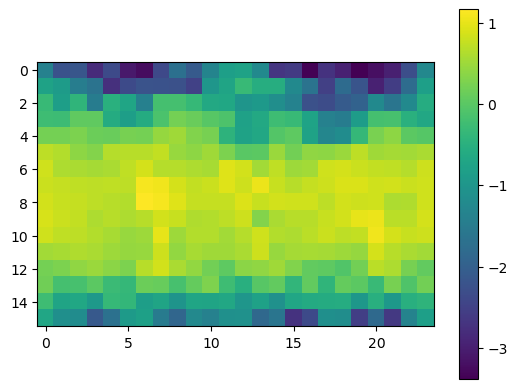

In [10]:
plt.imshow(y_sample[59].cpu().detach().numpy())
plt.colorbar()


# Playground

In [22]:
tconfig = diff.TrainingConfig()
tconfig.batch_size = 4

In [24]:
dataloader = DataLoader(train_ds, shuffle=tconfig.shuffle_data['train'], batch_size = tconfig.batch_size)

In [25]:
input_sample = next(iter(dataloader))
input_sample.shape

torch.Size([2, 128, 16, 24])

In [26]:
len(dataloader)

1

In [21]:
torch.manual_seed(0)
np.random.seed(0)

In [120]:
input_sample.shape

torch.Size([4, 128, 16, 24])

### Sampling $x_t$ from markov chain
[DDPM Paper](https://arxiv.org/pdf/2006.11239)
Given a **fixed** noise schedule $\{\beta_1, ..., \beta_T\}$, we can define $\alpha_t:= 1- \beta_t$ and $\bar{\alpha_t} = \prod_{s=1}^t \alpha_s$

Giving rules for products of gaussians, we can conveniently sample from any arbitrary node in the Markov Chain as long as we condition on $x_0$. $$q(x_t|x_0) = \mathcal N(\sqrt{\bar{\alpha_t}} \cdot x_0, (1-\bar{\alpha_t}) I)$$

Given a sample $\epsilon$ drawn from a standard gaussian, we leverage this to reparameterize $$x_t(x_0, \epsilon) = \sqrt{\bar{\alpha_t}} \cdot x_0 + \sqrt{1-\bar{\alpha_t}} \cdot \epsilon$$


The loss, which can also be interpreted as training a noise-conditional score based model, is (14) from the paper: $$L_{simple} := \mathbb{E} [||\epsilon - \epsilon_\theta(x_t(x_0, \epsilon, t), t)||^2]$$

In [1]:
train_steps = 100

In [2]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=train_steps) # in charge of betas
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 100,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [3]:
print(noise_scheduler.config.num_train_timesteps)
print(noise_scheduler.timesteps)
noise_scheduler.set_timesteps(10)
noise_scheduler.timesteps

100
tensor([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82,
        81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64,
        63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46,
        45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28,
        27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,
         9,  8,  7,  6,  5,  4,  3,  2,  1,  0])


tensor([90, 80, 70, 60, 50, 40, 30, 20, 10,  0])

In [ ]:
noise_scheduler.set_timesteps(train_steps) # reset

In [32]:
def get_alpha_t_manual(t, scheduler=noise_scheduler):
    a = 1
    for s in range(t+1):
        a = a * (1-scheduler.betas[s])
    return(a)
print(get_alpha_t_manual(5) - noise_scheduler.alphas_cumprod[5])
noise_scheduler.alphas_cumprod[:6]

tensor(0.)


tensor([0.9999, 0.9996, 0.9991, 0.9984, 0.9975, 0.9964])

In [52]:
def sample_xt(x0, t):
    eps = torch.randn(x0.shape) # BS x C x H x W
    xt = noise_scheduler.add_noise(x0, eps, torch.LongTensor(t)) # noisy image
    return(xt, eps)

In [35]:
t = 50

In [53]:
x50, eps = sample_xt(input_sample, [t])

In [55]:
at = noise_scheduler.alphas_cumprod[t]
x50_manual = torch.sqrt(at) * input_sample + torch.sqrt(1-at)*eps

In [56]:
loss_fn = torch.nn.MSELoss()

In [57]:
loss_fn(x50_manual, x50) # the same! 

tensor(0.)

Loss called to match model prediction to actual noise used to generate noisy latent. 

training_loss = loss_fn(model(x_t, t).sample, epsilon_noise_sample)

In [63]:
eps.shape

torch.Size([4, 128, 16, 24])

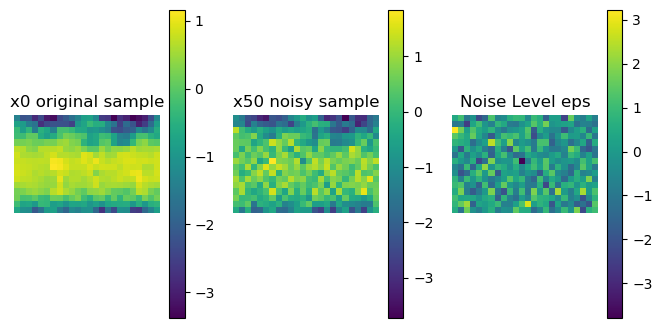

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

im0 = axes[0].imshow(input_sample.permute(0, 2, 3, 1).cpu().numpy()[0, :, :, 59], 'viridis')
axes[0].title.set_text("x0 original sample")
axes[0].set_axis_off()

im1 = axes[1].imshow(x50.permute(0, 2, 3, 1).cpu().numpy()[0, :, :, 59], 'viridis')
axes[1].set_axis_off()
axes[1].title.set_text("x50 noisy sample")

im2 = axes[2].imshow(eps[0, 59, :, :], 'viridis')
axes[2].set_axis_off()
axes[2].title.set_text("Noise Level eps")

fig.colorbar(im0, ax=axes[0], orientation='vertical')
fig.colorbar(im1, ax=axes[1], orientation='vertical')
fig.colorbar(im2, ax=axes[2], orientation='vertical')
plt.show()

### testing speed 

In [62]:
class DiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, image_dataset, mconfig):
        self.dataset = image_dataset
        self.scheduler = image_dataset.scheduler
        self.device = image_dataset.device
        self.num_timesteps = self.scheduler.config.num_train_timesteps
        self.sample_shape = image_dataset[0].shape
        self.static_noise = torch.randn(self.sample_shape, device=self.device)
    
    def __len__(self):
        return(len(self.dataset))

    def __getitem__(self, idx, timestep=-1, static=False):
        clean_image = self.dataset[idx]
        noise = self.static_noise if static else torch.randn(clean_image.shape, device=self.device)
        timestep = torch.randint(0, self.num_timesteps, size=(1,), device=self.device, dtype=torch.int64)
        noisy_image = self.scheduler.add_noise(clean_image, noise, timestep)
        return(noisy_image, timestep, noise)

diffds = DiffusionDataset(train_ds, mconfig)
dl = DataLoader(train_ds, batch_size=tconfig.batch_size, shuffle=False)
def custom_cfn(batch):
    noisy_images = torch.stack([item[0] for item in batch])  # Shape [N, C, H, W]
    timesteps = torch.cat([item[1] for item in batch])  # Shape [N]
    noise = torch.stack([item[2] for item in batch])  # Shape [N, C, H, W]
    return noisy_images, timesteps, noise
diffdl = DataLoader(diffds, batch_size=tconfig.batch_size, shuffle=False, collate_fn=custom_cfn)



In [63]:
%%timeit
for step, batch in enumerate(dl):
    noisy_images, timesteps, noise = dl.dataset.noise_batch(batch)

48.3 ms ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
# definitely slower
%%timeit
for step, batch in enumerate(diffdl):
    noisy_images, timesteps, noise = batch

217 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### How Reverse Diffusion with trained model works

Given $\epsilon$, we can obtain the distribution for a reverse diffusion step. Recall that $$p_\theta(x_{t-1} | x_t) := \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta=\sigma_t^2 I)$$
where $\sigma_t^2=\beta_t$ is a common choice. 


$$x_{t-1} =\dfrac{1}{\alpha_t}\left(x_t - \dfrac{\beta_t}{\sqrt{1-\alpha_t}} \epsilon_\theta(x_t, t)\right) + \sigma_t z \,\,\,\,\,\, z \sim \mathcal N(0, I)$$

More simply, since $x_t = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \sigma_t$, then $x_{t-1} = \dfrac{1}{\alpha_t}(x_t - \sqrt{\beta_t} \epsilon_\theta)$

In [68]:
noise_scheduler.timesteps

tensor([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82,
        81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64,
        63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46,
        45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28,
        27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,
         9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [70]:
x50.shape, eps.shape

(torch.Size([4, 128, 16, 24]), torch.Size([4, 128, 16, 24]))

In [78]:
gen = torch.Generator()

In [97]:
x49 = noise_scheduler.step(eps, timestep=50, sample=x50, generator=gen).prev_sample

In [98]:
x49b = noise_scheduler.step(eps, timestep=50, sample=x50, generator=gen).prev_sample

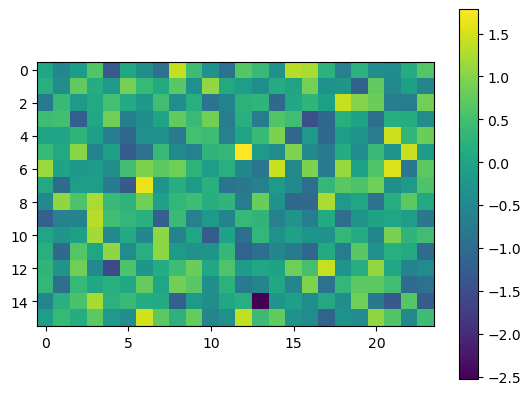

In [103]:
sigma_diff = (x49 - x49b) / np.sqrt(noise_scheduler.betas[50])
plt.imshow(sigma_diff[0,59,:,:]/2)
plt.colorbar()

In [92]:
def manual_inference_step(epsilon, t, xt, scheduler):
    # x t-1
    bt = noise_scheduler.betas[t]
    x = xt - np.sqrt(bt) * epsilon
    x = x / np.sqrt(1 - bt)
    return(x)

In [104]:
def run_pipeline(model, scheduler):
    # get x t-1 given x_t
    input =  torch.randn(input_sample.shape)
    for t in scheduler.timesteps:
        with torch.no_grad():
            noisy_residual = model(input, t).sample
        previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
        input = previous_noisy_sample


## U Net Model

Ok so we have our noisy dataset and our well defined task. Let's explore the model!

- U Net at its core is a convolution based encoder decoder architecture that progressively reduces height/width dimensionality but adds channels with "down blocks" and rescales with "upblocks". Residual connections as well
- Timestep is fed into noise-conditional model via a time embedding. "temb" is a parameter in all the downsample blocks


Resources: 
- [Time Embeddings and conditioning](https://varun-ml.github.io/posts/diffusion-models/denoising-diffusion-models-2/)

In [212]:
@dataclass
class DiffusionModelConfig:
    model_type: str = "diffusion"
    image_height = 16
    image_width  = 24
    in_channels: int = 128
    latent_dims: int = 16
    out_channels: int = 128
    block_out_channels: Tuple = field(default_factory=lambda: (32, 64, 64, 128))  # num output channel for each UNet block
    down_blocks: Tuple = field(default_factory=lambda: (
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ))
    up_blocks: Tuple = field(default_factory=lambda: (
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
    ))

In [213]:
def load_model(config, device):
    registered = ['VAE', 'diffusion', 'latent_diffusion']
    match config.model_type:
        case "VAE":
            model = VariationalAutoencoder(
                data_dims= config.num_channels, 
                latent_dims= config.latent_dims, 
                hidden_dims= config.ae_hidden_dims, 
                device = device,
            )
        case model_type if "diffusion" in model_type:
            channels = config.latent_dims if 'latent' in model_type else config.in_channels
            model = diffusers.UNet2DModel(
                sample_size=(config.image_height, config.image_width),  # the target image resolution
                in_channels=channels,  # the number of input channels, 3 for RGB images
                out_channels=channels,  # the number of output channels
                layers_per_block=1,  # how many ResNet layers to use per UNet block
                block_out_channels=config.block_out_channels, 
                down_block_types=config.down_blocks, 
                up_block_types=config.up_blocks,
                norm_num_groups=16, 
            ).to(device)
    return(model)

#### Regular Model (no latent space)

In [41]:
mconfig = DiffusionModelConfig()
mconfig

DiffusionModelConfig(model_type='diffusion', in_channels=128, latent_dims=16, out_channels=128, block_out_channels=(32, 64, 64, 128), down_blocks=('DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D'), up_blocks=('UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D'))

In [43]:
model = load_model(mconfig, device)

In [45]:
#print(isinstance(layers[1], diffusers.models.embeddings.Timesteps))
t = torch.tensor([1, 2, 3, 4])

In [46]:
output = model(input_sample, timestep=0)
output.sample.shape

NameError: name 'input_sample' is not defined

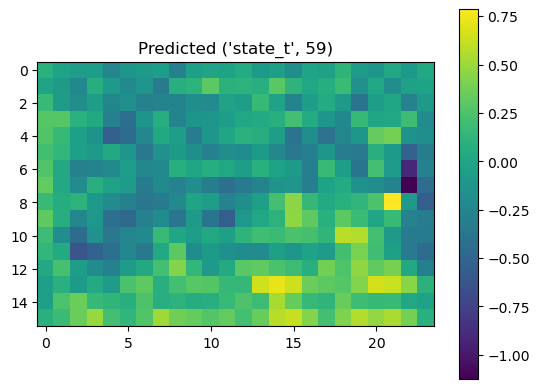

In [71]:
plt.imshow(output.sample[0].cpu().detach().numpy()[59])
plt.title(f"Predicted {train_ds.mlo[59].item()}")
plt.colorbar()
plt.show()

## Latent Diffusion

Following diffusers [source code](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unets/unet_2d.py#L243)

In [47]:
class UnconditionalDiffusion(nn.Module):
    def __init__(self, encoder, decoder, unet):
        self.encoder = encoder
        self.decoder = decoder
        self.unet = unet

    def forward(self, noisy_sample):
        noisy_latent = self.encoder(noisy_sample)
        denoised_latent = self.unet(noisy_latent)
        denoised_sample = self.decoder(denoised_latent)

        return(denoised_sample)

In [107]:
lconfig = DiffusionModelConfig()
lconfig.model_type = "latent_diffusion"
lconfig.block_out_channels = (32, 64)
lconfig.down_blocks = ("DownBlock2D", "DownBlock2D")
lconfig.up_blocks = ("UpBlock2D", "UpBlock2D")

In [108]:
ldm = load_model(lconfig, device)

In [194]:
input_sample = torch.randn(4, 16, 16, 24)
ts = [5, 8, 2, 6]

#### How the time embeddings work: 

In [127]:
def time_embed_fwd(self,
    sample: torch.Tensor,
    timestep: Union[torch.Tensor, float, int],
    class_labels: Optional[torch.Tensor] = None,
    ) -> Tuple:
    timesteps = timestep
    if not torch.is_tensor(timesteps):
        timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
    elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
        timesteps = timesteps[None].to(sample.device)

    # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
    timesteps = timesteps * torch.ones(sample.shape[0], dtype=timesteps.dtype, device=timesteps.device)
    t_emb = self.time_proj(timesteps)

    # timesteps does not contain any weights and will always return f32 tensors
    # but time_embedding might actually be running in fp16. so we need to cast here.
    # there might be better ways to encapsulate this.
    t_emb = t_emb.to(dtype=self.dtype)
    emb = self.time_embedding(t_emb)
    
    if self.class_embedding is not None:
        if class_labels is None:
            raise ValueError("class_labels should be provided when doing class conditioning")

        if self.config.class_embed_type == "timestep":
            class_labels = self.time_proj(class_labels)
        class_emb = self.class_embedding(class_labels).to(dtype=self.dtype)
        emb = emb + class_emb
    elif self.class_embedding is None and class_labels is not None:
        raise ValueError("class_embedding needs to be initialized in order to use class conditioning")
    return(timesteps, t_emb, emb)

[source code](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/embeddings.py)

1. First the timesteps are processed to ensure that they match the batch size, meaning we have N proper copies of model(x_t, t).
2. The Timesteps class calls get_timestep_embedding which creates sinusoidal embeddings (something something sin-cos of $e^{f(t)}$). For each timestep, creates a 32 dimensional positional embedding
3. From these 32 dim time_embedding vectors, the model's TimestepEmbedding is a learned nn.Module that further projects the embedding into a final 128 dimensional embedding. Presumably this is a learned projection.

Eventually, these conditioned embeddings are fit into our blocks

In [128]:
type(ldm.time_proj), type(ldm.time_embedding)

(diffusers.models.embeddings.Timesteps,
 diffusers.models.embeddings.TimestepEmbedding)

In [129]:
ldm.time_embedding

TimestepEmbedding(
  (linear_1): Linear(in_features=32, out_features=128, bias=True)
  (act): SiLU()
  (linear_2): Linear(in_features=128, out_features=128, bias=True)
)

In [130]:
timesteps, temb, emb = time_embed_fwd(ldm, sample, timestep=torch.tensor(ts))

In [131]:
temb.shape, emb.shape # both are torch tensors

(torch.Size([4, 32]), torch.Size([4, 128]))

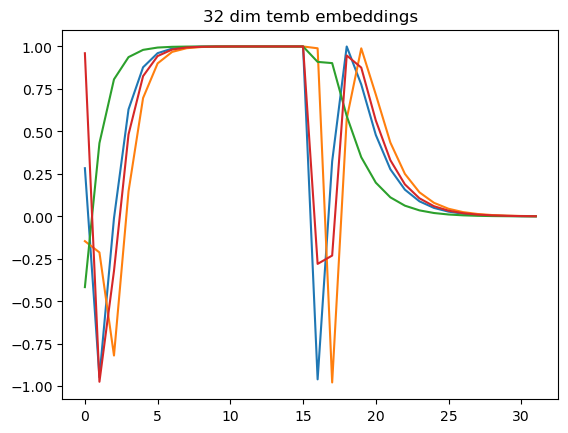

In [132]:
for i in range(4):
    plt.plot(temb[i])
plt.title("32 dim temb embeddings")
plt.show()

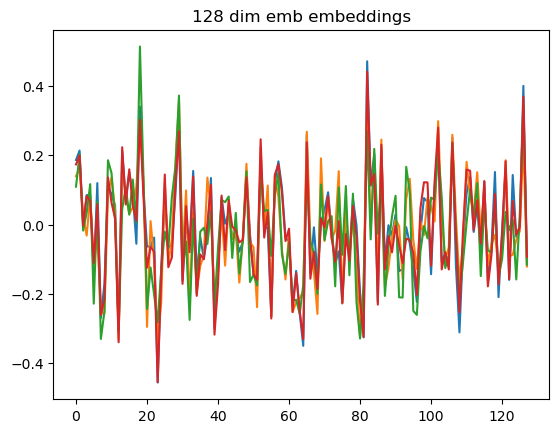

In [133]:
emb = emb.detach().numpy()
for i in range(4):
    plt.plot(emb[i])

plt.title("128 dim emb embeddings")
plt.show()

In [134]:
ldm.time_proj

Timesteps()

#### How the down blocks work

In [160]:
timesteps, temb, emb = time_embed_fwd(ldm, sample, timestep=torch.tensor(ts))

In [161]:
skip_sample = input_sample
sample = ldm.conv_in(input_sample)

skip_sample.shape, sample.shape

(torch.Size([4, 16, 16, 24]), torch.Size([4, 32, 16, 24]))

In [162]:
def down_blocks_fwd(self, sample: torch.Tensor, emb, skip_sample, ) -> Tuple:
    down_block_res_samples = (sample,)
    for downsample_block in self.down_blocks:
        if hasattr(downsample_block, "skip_conv"):
            sample, res_samples, skip_sample = downsample_block(
                hidden_states=sample, temb=emb, skip_sample=skip_sample
            )
        else:
            sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

        down_block_res_samples += res_samples
    return(sample, res_samples, skip_sample, down_block_res_samples)
    

In [163]:
(1,) + (2,) # tuple addition is concat; down_block_res_samples stores all res blocks

(1, 2)

In [164]:
sample, res_samples, skip_sample, down_block_res_samples = down_blocks_fwd(ldm, sample, emb, skip_sample)

In [176]:
sample.shape, len(res_samples), res_samples[0].shape, skip_sample.shape, 

(torch.Size([4, 64, 8, 12]),
 1,
 torch.Size([4, 64, 8, 12]),
 torch.Size([4, 16, 16, 24]))

In [177]:
for i in down_block_res_samples:
    print(i.shape)


torch.Size([4, 32, 16, 24])
torch.Size([4, 32, 16, 24])
torch.Size([4, 32, 8, 12])
torch.Size([4, 64, 8, 12])


In [168]:
lconfig.block_out_channels

(32, 64)

- conv_in goes from in_channels to block[0]
- first downblock is block[0] to block[0]
- then each one is $i-1 \rightarrow i$ for i in range(1, len(block)-1)
Then, for 

In [187]:
ldm.conv_in(input_sample).shape

torch.Size([4, 32, 16, 24])

In [188]:
sample, resid = ldm.down_blocks[0](ldm.conv_in(input_sample), emb, input_sample)

In [191]:
resid[0].shape, resid[1].shape

(torch.Size([4, 32, 16, 24]), torch.Size([4, 32, 8, 12]))

### How the up blocks work

In [199]:
def up_blocks_fwd(self, sample: torch.Tensor, emb, down_block_res_samples) -> Tuple:
    skip_sample = None
    for upsample_block in self.up_blocks:
        res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
        down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

        if hasattr(upsample_block, "skip_conv"):
            sample, skip_sample = upsample_block(sample, res_samples, emb, skip_sample)
        else:
            sample = upsample_block(sample, res_samples, emb)
    return(sample, skip_sample)

### All together

In [200]:
def forward(self,
    sample: torch.Tensor,
    timestep: Union[torch.Tensor, float, int],
    class_labels: Optional[torch.Tensor] = None,
    ):
    r"""
    The [`UNet2DModel`] forward method.

    Args:
        sample (`torch.Tensor`):
            The noisy input tensor with the following shape `(batch, channel, height, width)`.
        timestep (`torch.Tensor` or `float` or `int`): The number of timesteps to denoise an input.
        class_labels (`torch.Tensor`, *optional*, defaults to `None`):
            Optional class labels for conditioning. Their embeddings will be summed with the timestep embeddings.
        return_dict (`bool`, *optional*, defaults to `True`):
            Whether or not to return a [`~models.unets.unet_2d.UNet2DOutput`] instead of a plain tuple.

    Returns:
        [`~models.unets.unet_2d.UNet2DOutput`] or `tuple`:
            If `return_dict` is True, an [`~models.unets.unet_2d.UNet2DOutput`] is returned, otherwise a `tuple` is
            returned where the first element is the sample tensor.
    """
    # 0. center input if necessary
    if self.config.center_input_sample:
        sample = 2 * sample - 1.0

    # 1. time
    timesteps, t_emb, emb = time_embed_fwd(self, sample, timestep, class_labels)
    # 2. pre-process
    skip_sample = sample
    sample = self.conv_in(sample)

    # 3. down
    sample, res_samples, skip_sample, down_block_res_samples = down_blocks_fwd(self, sample, emb, skip_sample, )

    # 4. mid
    sample = self.mid_block(sample, emb)

    # 5. up
    sample, skip_sample = up_blocks_fwd(self, sample, emb, down_block_res_samples)

    # 6. post-process
    sample = self.conv_norm_out(sample)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)

    if skip_sample is not None:
        sample += skip_sample

    if self.config.time_embedding_type == "fourier":
        timesteps = timesteps.reshape((sample.shape[0], *([1] * len(sample.shape[1:]))))
        sample = sample / timesteps

    return (sample)

In [201]:
input_sample = torch.randn(4, 16, 16, 24)
ts = [5, 8, 2, 6]

In [202]:
output = forward(ldm, input_sample, torch.tensor(ts))

In [204]:
ldm_output = ldm(input_sample, torch.tensor(ts))

In [205]:
(output == ldm_output.sample).all()

tensor(True)

In [206]:
output.shape

torch.Size([4, 16, 16, 24])

# Actual Training

Helpful links on training troubleshooting:
- [underfitting](https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn)
- [Unit testing ML](https://thenerdstation.medium.com/how-to-unit-test-machine-learning-code-57cf6fd81765)

In [11]:
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
def load_scheduler(config):
    match config.scheduler_type.lower():
        case sched if 'ddpm' in sched:
            return(DDPMScheduler(num_train_timesteps=config.num_timesteps)) # in charge of betas
        case _:
            print("Only support for ddpm as of now")

def load_lr_scheduler(config, optim, dataloader):
    lr = get_cosine_schedule_with_warmup(
        optimizer=optim, 
        num_warmup_steps=config.lr_warmup_steps, 
        num_training_steps=len(dataloader) * config.num_epochs,
    )
    return(lr)

### Training Debugging

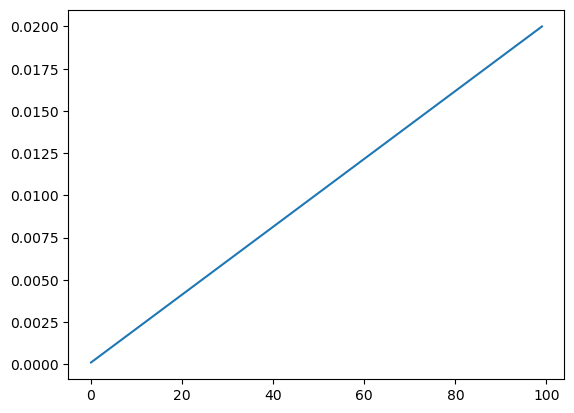

In [14]:
scheduler = load_scheduler(mconfig)
plt.plot(scheduler.betas)

In [67]:
#diff.trainers.AbstractTrainer
class DiffusionTrainer(diff.trainers.AbstractTrainer):
    def __init__(self, model, datasets, loss_fn, tconfig, mconfig, exp_id, rank=0):
        super().__init__(model, datasets, loss_fn, tconfig, exp_id, rank)
        self.model_config = mconfig
    
    def _run_batch(self, batch, phase='train'):
        noisy_images, timesteps, noises = batch
        noise_pred = self.model(noisy_images, timesteps.flatten()).sample
        loss = self.loss_fn(noise_pred, noises)
        if(phase == 'train'):
            self.optimizer.zero_grad()
            loss.backward()
            if(self.training_config.clip_gradients):
                total_grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
    
        return(loss)

    def _run_epoch(self, epoch, phase='train'):
        self.model.train(phase=='train')
        total_loss = 0
        with torch.set_grad_enabled(phase=='train'):
            if(self.distributed):
                dataloader.sampler.set_epoch(epoch)
            for step, clean_batch in enumerate(self.dataloaders['train']):
                batch = self.datasets['train'].noise_batch(clean_batch)
                loss = self._run_batch(batch, phase)
                total_loss += loss.item()
            
        return(total_loss / len(self.dataloaders['train']))
    
    def _log_epoch_info(self, epoch_num, loss):
        self.losses['train'].append(loss)
        if(epoch_num % self.training_config.epoch_logging_interval == 0):
            print(f"epoch {epoch_num}: [{loss}]")
        if(loss < self.best_loss and self.training_config.save_best_epoch):
            self.best_loss = loss
            self._save_checkpoint(epoch_num, cid='best')
        
        
    def train(self, num_epochs=0, log=True, trial=''):
        self.setup_training(num_epochs)
        print(f"Training for {self.training_config.num_epochs} epochs")
        for epoch in range(self.training_config.num_epochs):
            loss = self._run_epoch(epoch)
            self._log_epoch_info(epoch, loss)
        self.finish_training(log, trial)
    
    def setup_training(self, num_epochs):
        super().setup_training(num_epochs)
        if(num_epochs): # passed in number of training epochs is non zero
            self.training_config.num_epochs = num_epochs
        for phase in self.phases:
            self.losses[phase] = []
        self.best_loss = 10

    def finish_training(self, log, trial):
        print("Finished training")
        if(log):
            log_dict = {
                "training_config" : asdict(self.training_config), 
                "model_config" : asdict(self.model_config)
            }
            for phase in self.phases:
                log_dict[f'{phase}_loss'] = self.losses[phase]
            #if(self.training_config.log_gradients):
            #    log_dict['gradients'] = self.gradients

            with open(os.path.join(self.dirs['log_dir'], f"trial_{trial}_log.json"), 'w') as f:
                json.dump(log_dict, f)
            return(log_dict)

#### Overfitting two samples

In [27]:
two_sample_ds = ClimsimImageDataset(Xarr[:2*384], Yarr[:2*384], mconfig, device=device, normalize=True)

Normalizing data


In [28]:
tconfig.shuffle_data

{'train': False, 'eval': False}

In [30]:
#two_sample_dl = DataLoader(two_sample_ds, shuffle=tconfig.shuffle_data['train'], batch_size=2)
two_sample_dl = DataLoader(two_sample_ds, shuffle=tconfig.shuffle_data['train'], batch_size=2)

In [32]:
batch = next(iter(two_sample_dl))
noisy_images, timesteps, noise = two_sample_dl.dataset.noise_batch(batch)

In [33]:
optimizer = diff.trainers.create_optimizer(model, tconfig)
lr_scheduler = load_lr_scheduler(tconfig, optimizer, two_sample_dl)

In [35]:
pred = model(noisy_images, timesteps).sample

In [37]:
loss = loss_fn(pred, noise)
loss

tensor(1.1295, device='cuda:0', grad_fn=<MseLossBackward0>)

In [38]:
loss.backward()

In [39]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(1.0557, device='cuda:0')

In [40]:
torch.norm(list(model.parameters())[0].grad)

tensor(0.3499, device='cuda:0')

In [114]:
"""
mps = list(model.parameters())
tmps = list(trainer.model.parameters())

torch.norm(mps[0]),  torch.norm(tmps[0])

new_init = []
trained = []

for p in model.parameters():
    new_init.append(torch.norm(p).item())
for p in trainer.model.parameters():
    trained.append(torch.norm(p).item())
"""
1

1

In [57]:
dset = {'train' : two_sample_ds}
trainer = DiffusionTrainer(model, dset, loss_fn, tconfig, mconfig, exp_id='two_sample_diffusion')
#trainer.dataloaders = {'train' : two_sample_dl}
#trainer.batch = next(iter(two_sample_dl)) # use same noise every time
trainer.train(1000)

Training for 1000 epochs
epoch 0: [0.7730326652526855]
epoch 25: [0.7542222738265991]
epoch 50: [0.7496830821037292]
epoch 75: [0.7148858904838562]
epoch 100: [0.7115294337272644]
epoch 125: [0.7384872436523438]
epoch 150: [0.8504878878593445]
epoch 175: [0.7458630800247192]
epoch 200: [0.9407676458358765]
epoch 225: [0.6731176376342773]
epoch 250: [0.6640271544456482]
epoch 275: [0.6600327491760254]
epoch 300: [0.6695224046707153]
epoch 325: [0.7102698087692261]
epoch 350: [0.647002637386322]
epoch 375: [0.6917632818222046]
epoch 400: [0.6635643243789673]
epoch 425: [0.6045785546302795]
epoch 450: [0.8041671514511108]
epoch 475: [0.7236301898956299]
epoch 500: [0.588153600692749]
epoch 525: [0.5826186537742615]
epoch 550: [0.5954960584640503]
epoch 575: [0.5929807424545288]
epoch 600: [0.5719040632247925]
epoch 625: [0.573508620262146]
epoch 650: [0.5640008449554443]
epoch 675: [0.6378196477890015]
epoch 700: [0.548387885093689]
epoch 725: [0.5476928949356079]
epoch 750: [0.5409368872

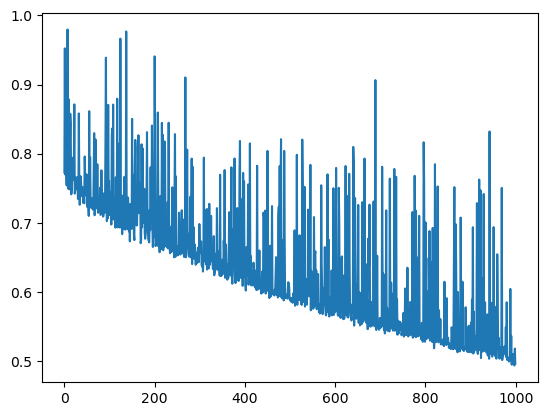

In [58]:
plt.plot(trainer.losses)

## Actual Training

In [9]:
tconfig = diff.TrainingConfig()
tconfig.run_id = 'diffusion_testing_full1'
tconfig.phases = ['train']
tconfig.lr_scheduler = 'get_cosine_schedule_with_warmup'
tconfig.num_epochs = 100
tconfig.lr_warmup_steps = 10
tconfig.epoch_logging_interval = 1
tconfig.model_checkpointing_interval = 5
tconfig.log_gradients = False
tconfig.train_test_split=[1.0]
tconfig

TrainingConfig(train_test_split=[1.0], phases=['train'], num_epochs=100, distributed_training=False, shuffle_data={'train': False, 'eval': False}, batch_size=32, xarr_subsamples=(36, 210240, 144), optimizer='adam', lr_scheduler='get_cosine_schedule_with_warmup', learning_rate=0.0001, beta=0.2, clip_gradients=True, save_best_epoch=True, batch_logging_interval=4, model_checkpoint_interval=2, log_gradients=False, push_to_hub=False)

In [10]:
mconfig = diff.ModelConfig()
mconfig.model_type = "ddpm_diffusion"
mconfig.block_out_channels = (128, 256, 512)
mconfig.down_blocks = ("DownBlock2D", "DownBlock2D", "DownBlock2D")
mconfig.up_blocks = ("UpBlock2D", "UpBlock2D", "UpBlock2D")
mconfig

ModelConfig(model_type='ddpm_diffusion', data_vars='v1', scheduler_type='ddpm', unet=UNetParams(sample_size=(16, 24), in_channels=128, out_channels=128, block_out_channels=(32, 64, 64, 128), down_block_types=('DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D'), up_block_types=('UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D'), layers_per_block=1, norm_num_groups=4), scheduler=SchedulerParams(num_train_timesteps=100, beta_schedule='linear', clip_sample=False, clip_sample_range=4.0), num_channels=128, latent_dims=16, ae_hidden_dims=[64, 32, 16], disable_enc_logstd_bias=True)

In [13]:
model = diff.load_model(mconfig)
#model.load_state_dict(torch.load("experiments/test_ddpm_1/e24-ckpt.pt"))


In [ ]:
loss_fn = torch.nn.MSELoss()
datasets = {"train" : train_ds}

In [22]:
#dataloaders = {"train" : DataLoader(train_ds, shuffle=
#for n, p in model.named_parameters():
#    print(f"{n}, {p.shape}")

In [91]:
trainer = DiffusionTrainer(model, datasets, loss_fn, tconfig, mconfig, exp_id='test_ddpm_1')

In [92]:
trainer.train(num_epochs=18, log=True, trial='alpha_cont')

Getting ready to train model
Training for 18 epochs
epoch 0: [0.542369799769443]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 1: [0.5374854854915453]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 2: [0.5302643076233242]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 3: [0.5183956273224043]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 4: [0.5196712982395421]
epoch 5: [0.5189830032379731]
epoch 6: [0.507175057478573]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 7: [0.5053737033968386]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 8: [0.5082743141962134]
epoch 9: [0.49762143453826074]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 10: [0.49448292410891986]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 11: [0.4904575684796209]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoch 12: [0.4906931117824886]
epoch 13: [0.4847589543332224]
Model saved at experiments/test_ddpm_1/best-ckpt.pt
epoc

In [127]:
log = json.load(open('experiments/test_ddpm_1/trial_alpha_log.json'))

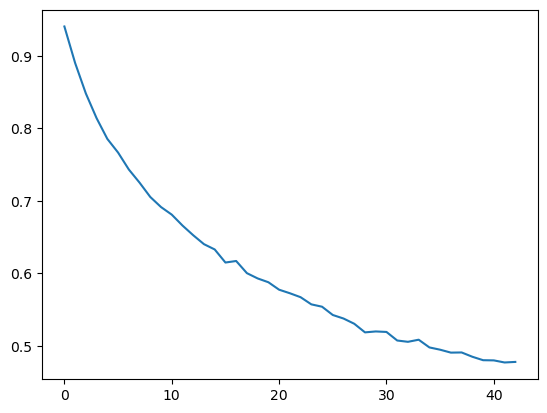

In [128]:
plt.plot(log['train_loss'] )

In [86]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = load_lr_scheduler(tconfig, )

In [90]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device=device).manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [259]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path


In [265]:
next(iter(dataloader)).shape

torch.Size([8, 128, 16, 24])

In [291]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        #log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")


    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, clean_images in enumerate(train_dataloader):
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        try:
            if accelerator.is_main_process:
                pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
                if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                    evaluate(config, epoch, pipeline)
    
                if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                    if config.push_to_hub:
                        upload_folder(
                            repo_id=repo_id,
                            folder_path=config.output_dir,
                            commit_message=f"Epoch {epoch}",
                            ignore_patterns=["step_*", "epoch_*"],
                        )
                    else:
                        pipeline.save_pretrained(config.output_dir)
        except: 
            print("Ran into error with sampling and evaluating")
        
        return(model)
        

In [287]:
config.save_model_epochs = 1
config.save_image_epochs = 1

In [288]:
config.output_dir

'model_outputs/'

In [289]:
config.num_epochs

1

In [292]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler)

model = notebook_launcher(train_loop, args, num_processes=1)

Launching training on CPU.


  0%|          | 0/16 [00:00<?, ?it/s]

Ran into error with sampling and evaluating
